# Анализ датасета 1985 Ward's Automotive Yearbook

## Подготовка окружения и импортирование данных

In [392]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation, linear_model, metrics, neighbors, svm, kernel_ridge, ensemble
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
with open('names.txt', 'r') as fin:
    names = list([line.strip() for line in fin])

In [4]:
# Импортируем датасет, заменяя вопросительные знаки на NaN

data = pd.read_csv('imports-85.data', na_values = ['?'], names = names)
data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [5]:
data.shape

(205, 26)

## Анализ исходных данных

Первая задача, которая просится к решению при первом просмотре исходных данных - анализ стоимость машины в зависимости от всех признаков (марка машины, мощность,тип двигателя и так далее) и определение наиболее значительных из них. Но эта задача носит скорее любопытный характер, нежели практически значимый.

Более полезной задачей для страховых компаний выглядит прогноз рейтинга риска (symboling) в зависимости от параметров.

Бытовой пользой обладает задача прогнозирования среднегодовой стоимости обслуживания автомобиля (normalized-losses).

Фанатам технической стороны автомобиля понравится поиск зависимости мощности двигателя и крутящего момента от различных параметров двигателя и топливной системы.

Экономные водители в первую очередь посчитают, какие параметры конструкции автомобиля повлияют на расход топлива, а также взглянули бы на разницу в значимых параметрах между расходом в городе и на трассе. Если бы в числе признаков были выбросы углекислого газа, то к ним бы присоединились экологи, которые выяснили бы какие марки автомобилей самые "грязные".

В качестве рабочей задачи выберу задачу прогноза среднегодовой стоимости обслуживания автомобиля. В этом случае мы решаем задачу регрессию с вектором ответов - normalized-losses.

Подготовим данные для обработки:

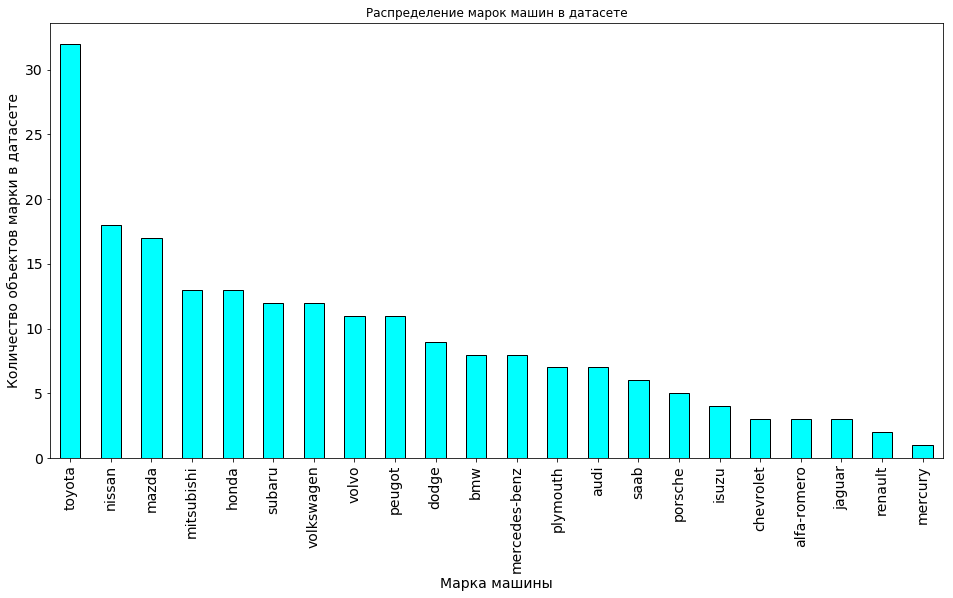

In [34]:
# Посмотрим на данные внимательнее
# Сперва оценим оценим распределение марок автомобилей в себе. Это не очень полезно практически, зато интересно.

data.make.value_counts().plot(kind = 'bar', figsize = (16, 8), color = 'aqua', edgecolor = 'black',
                             title = u'Распределение марок машин в датасете', fontsize = 14)
plt.xlabel(u'Марка машины', fontsize = 14)
plt.ylabel(u'Количество объектов марки в датасете', fontsize = 14)
plt.show()

In [93]:
# Разобьем признаки на вещественные и категориальные

real_features = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore',
                'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
category_features = ['symboling', 'make', 'body-style', 'drive-wheels', 'engine-type', 
                     'num-of-cylinders', 'fuel-system', 'fuel-type', 'aspiration', 
                     'num-of-doors', 'engine-location']

# Поскольку на распределение марок машин мы уже посмотрели, удалим этот признак из сета визуализации
cat_features = category_features.remove('make')

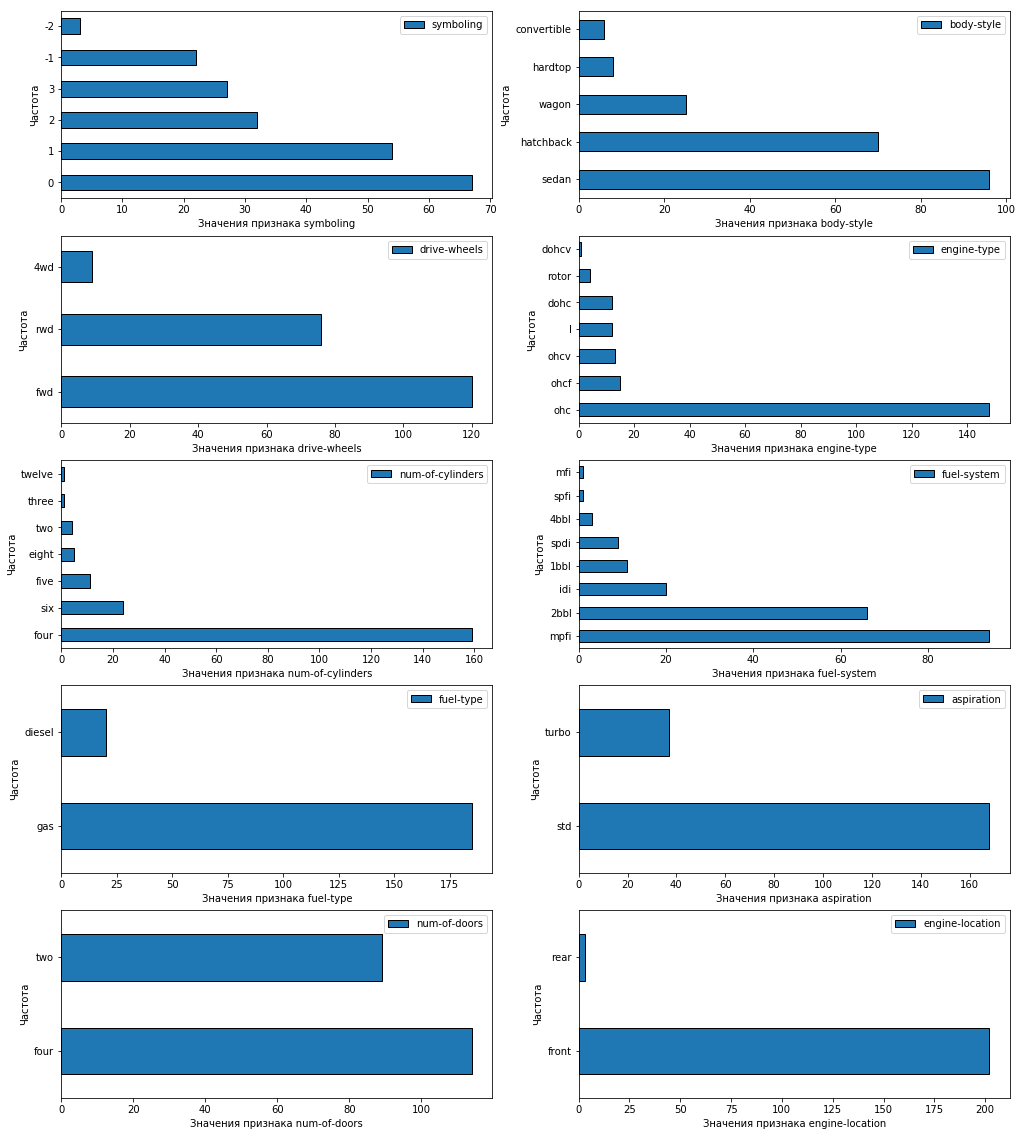

In [53]:
# Посмотрим на распределение значений остальных категориальных признаков

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(17, 20))

for idx, cat in enumerate(data[category_features]): 
    plt.subplot(5, 2, idx + 1)
    data[cat].value_counts().plot(label = cat, edgecolor = 'black', kind = 'barh')
    plt.legend()
    plt.ylabel(u'Частота')
    plt.xlabel(u'Значения признака %s' % cat)
plt.show()

По графикам видно, что некоторые из признаков распределены крайне неравномерно. К примеру, заднее расположение двигателя встречается только у трёх моделей из 205 (остальные с передним расположение). Это говорит о том, что признак engine-location неинформативен и может быть удален из анализа.

In [54]:
data['engine-location'].value_counts()

front    202
rear       3
Name: engine-location, dtype: int64

In [160]:
category_feat = ['symboling', 'make', 'body-style', 'drive-wheels', 'engine-type', 
                     'num-of-cylinders', 'fuel-system', 'fuel-type', 'aspiration', 'num-of-doors']

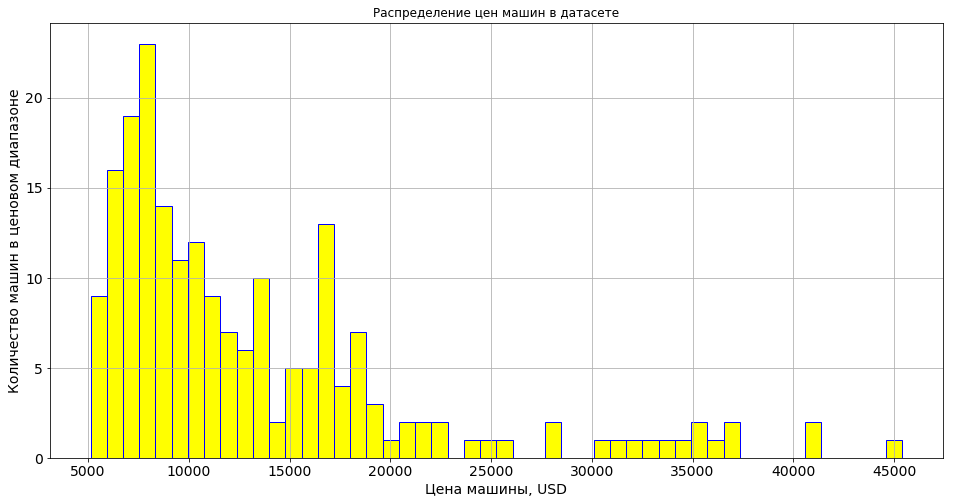

In [73]:
# Далее посмотрим на распределение вещественных признаков
# В первую очередь, на цену

data.price.plot(kind = 'hist', bins = 50, figsize = (16, 8), color = 'yellow', edgecolor = 'blue',
                             title = u'Распределение цен машин в датасете', fontsize = 14, grid = True)
plt.xlabel(u'Цена машины, USD', fontsize = 14)
plt.ylabel(u'Количество машин в ценовом диапазоне', fontsize = 14)
plt.show()

Как видим, большая часть машин представлена в относительно экономичном ценовом диапазоне. Следовательно, можно не опасаться большого количества выбросов из-за специфичности дорогих кастомных машин.

In [119]:
# Посмотрим на распределение значений остальных вещественных признаков

real_features = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore',
                'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

real_features1 = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore']
real_features2 = ['stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

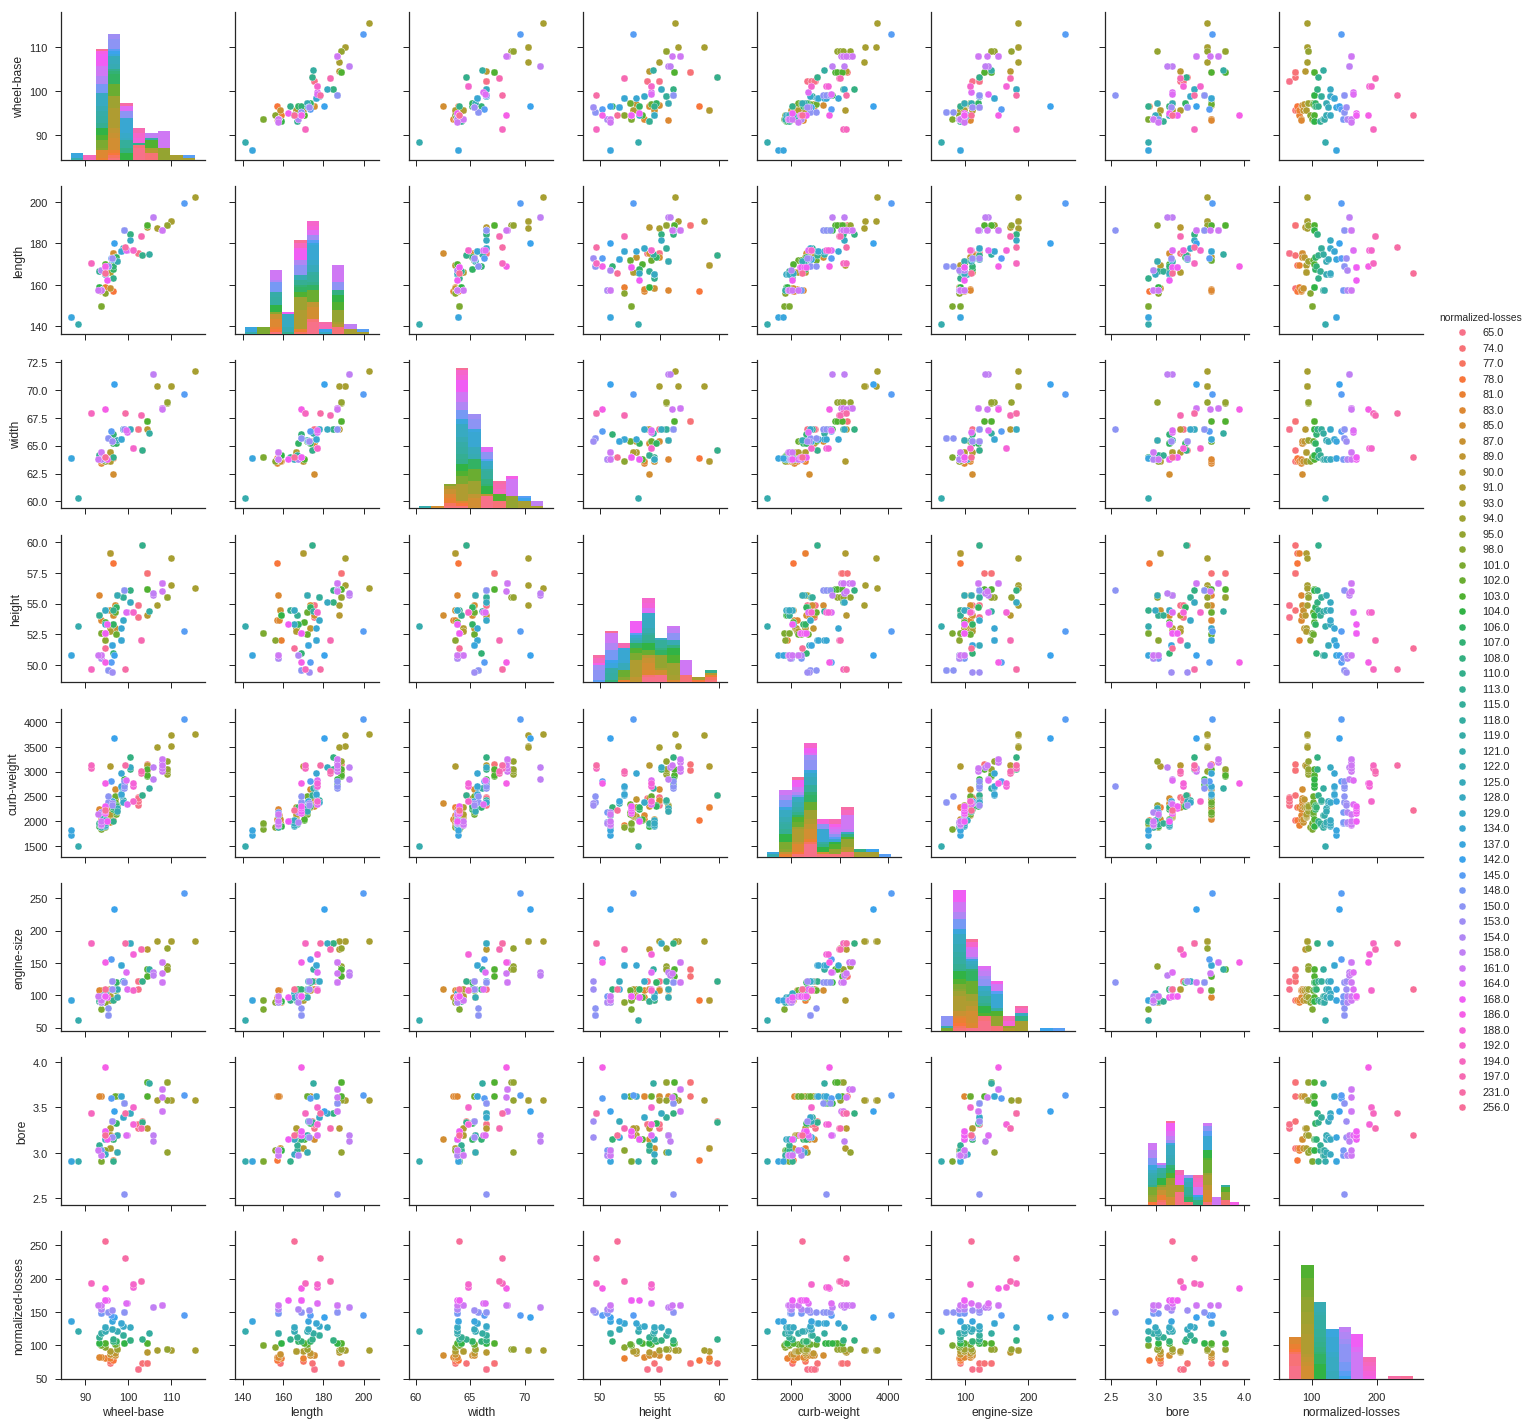

In [120]:
sns.pairplot(data[real_features1 + ['normalized-losses']], hue='normalized-losses')

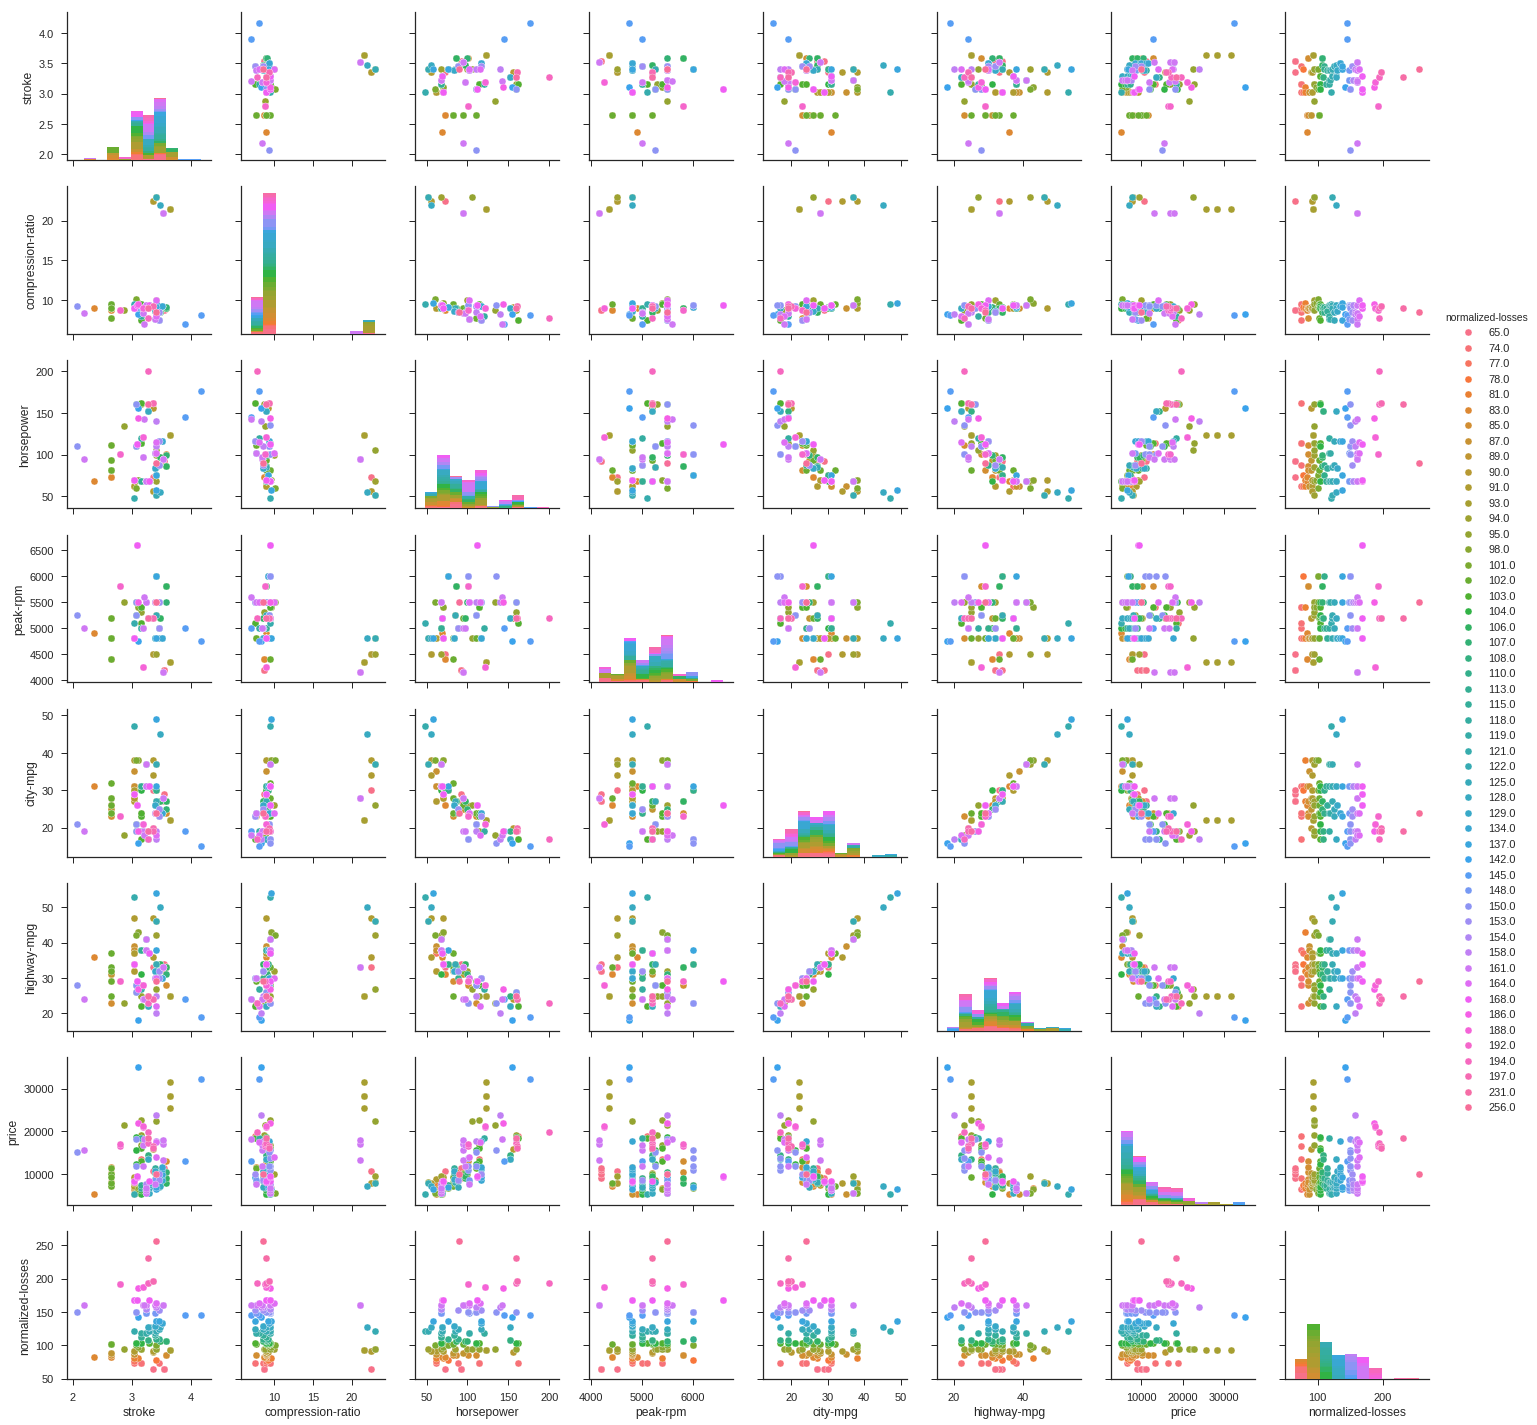

In [121]:
sns.pairplot(data[real_features2 + ['normalized-losses']], hue='normalized-losses');

In [150]:
# Чтобы избежать мультикорреляции и нестабильности модели, посмотрим на матрицу корреляций признаков

corr_matrix = data.corr(method = 'pearson')
corr_matrix

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.528667,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.134205,-0.008965,-0.178515,0.071622,0.274573,-0.035823,0.034606,-0.082391
normalized-losses,0.528667,1.000000,-0.074362,0.023220,0.105073,-0.432335,0.119893,0.167365,-0.036167,0.065627,-0.132654,0.295772,0.264597,-0.258502,-0.210768,0.203254
wheel-base,-0.531954,-0.074362,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.490378,0.161477,0.249786,0.352297,-0.361052,-0.470414,-0.544082,0.584642
length,-0.357612,0.023220,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.607480,0.129739,0.158414,0.555003,-0.287325,-0.670909,-0.704662,0.690628
width,-0.232919,0.105073,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559204,0.182956,0.181129,0.642482,-0.219957,-0.642704,-0.677218,0.751265
height,-0.541038,-0.432335,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.176195,-0.056999,0.261214,-0.110711,-0.322272,-0.048640,-0.107358,0.135486
curb-weight,-0.227691,0.119893,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.649045,0.168929,0.151362,0.751034,-0.266306,-0.757414,-0.797465,0.834415
engine-size,-0.105790,0.167365,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.594090,0.206675,0.028971,0.810773,-0.244618,-0.653658,-0.677470,0.872335
bore,-0.134205,-0.036167,0.490378,0.607480,0.559204,0.176195,0.649045,0.594090,1.000000,-0.055909,0.005203,0.577273,-0.264269,-0.594584,-0.594572,0.543436
stroke,-0.008965,0.065627,0.161477,0.129739,0.182956,-0.056999,0.168929,0.206675,-0.055909,1.000000,0.186170,0.090254,-0.071493,-0.042906,-0.044528,0.082310


In [154]:
# Чтобы не пропустить данных при визуальном анализе, формально выделим явно коррелирующие признаки

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix[corr_matrix.columns[i]].corr(corr_matrix[corr_matrix.columns[j]]) > 0.85:
            print (u'Корреляция между признаками %s и %s = %s' % 
            (corr_matrix.columns[i], corr_matrix.columns[j], 
             round(corr_matrix[corr_matrix.columns[i]].corr(corr_matrix[corr_matrix.columns[j]]), 3)))
    print



Корреляция между признаками wheel-base и length = 0.976
Корреляция между признаками wheel-base и width = 0.942
Корреляция между признаками wheel-base и curb-weight = 0.925
Корреляция между признаками wheel-base и bore = 0.855

Корреляция между признаками length и width = 0.985
Корреляция между признаками length и curb-weight = 0.981
Корреляция между признаками length и engine-size = 0.925
Корреляция между признаками length и bore = 0.925
Корреляция между признаками length и price = 0.928

Корреляция между признаками width и curb-weight = 0.993
Корреляция между признаками width и engine-size = 0.96
Корреляция между признаками width и bore = 0.928
Корреляция между признаками width и horsepower = 0.875
Корреляция между признаками width и price = 0.962


Корреляция между признаками curb-weight и engine-size = 0.978
Корреляция между признаками curb-weight и bore = 0.946
Корреляция между признаками curb-weight и horsepower = 0.903
Корреляция между признаками curb-weight и price = 0.978

Ко

Полагаться на голые цифры не стоит. Подключим здравый смысл. Анализ показывает, что высокой взаимной корреляцией обладают признаки колесная база, длина, ширина и вес автомобиля. Это выглядит логичным, так как от модели к модели эти параметры меняются все вместе: для одних машин они все велики, для других малы. Трудно отыскать широкую, но короткую машину. Или короткобазную, но тяжелую. Поэтому наличие всех этих признаков будет зашумлять модель.

Высокая корреляция диаметра поршня с весогабаритными характеристиками автомобиля не выглядит столь очевидной. Не углубляясь в нюансы автомобилестроения, предположим, что эта корреляция - совпадение.

Размер двигателя, диаметр поршня и мощность двигателя также имеют высокие показатели корреляции, но реальная взаимосвясь этих параметров не очевидна.

А вот расход топлива (точнее, расстояние, которое машина проходит на единице топлива) по городу и на трассе очевидно линейнейше взаимосвязаны, о чем и говорит высокое значение коэффициента корреляции. Уберем один из этих признаков.

In [152]:
# Новый набор вещественных признаков

real_feat = ['length', 'height', 'engine-size', 'bore', 'stroke', 'compression-ratio', 
             'horsepower', 'peak-rpm', 'city-mpg', 'price']

In [161]:
# Количество пустых полей для категориальных признаков

data[category_feat].isnull().sum()

symboling           0
make                0
body-style          0
drive-wheels        0
engine-type         0
num-of-cylinders    0
fuel-system         0
fuel-type           0
aspiration          0
num-of-doors        2
dtype: int64

In [162]:
# Количество пустых полей для вещественных признаков

data[real_feat].isnull().sum()

length               0
height               0
engine-size          0
bore                 4
stroke               4
compression-ratio    0
horsepower           2
peak-rpm             2
city-mpg             0
price                4
dtype: int64

Видим, что для 6 признаков, в которых есть пустые ячейки, их количество не превышает 4. Поэтому при размере датасета в 205 объектов их можно безболезненно удалить. Удаление объектов с пустыми normalized-loss значительно сократит объем данных, но поскольку в нашей задаче именно это целевой признак - придется использовать лишь те объекты, для которых значение целевого признака определено.

In [409]:
df = data.dropna()
df.shape

target_tree = df['normalized-losses']

In [91]:
df.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

In [254]:
# Поскольку данные отсортированы по марке машины, стоит перемешать данные для более точной оценки качества
# на кросс-валидации

df_shuffled = shuffle(df, random_state = 8)

Выделим целевой признак

In [255]:
target = df_shuffled['normalized-losses']

Категориальные признаки закодируем с бинарный формат

In [165]:
# Посмотрим на количество значений категориальных признаков, чтобы понять, 
# сколько новых признаков нам добавит бинарное кодирование

cat_values = 0
for cat in category_feat:
    print (u'Признак: %s' % cat)
    print (u'Число значений признака:')
    cat_values += len(df[cat].unique())
    print (len(df[cat].unique()))
    print
print (u'Общее число значений всех категориальных признаков = %s' % cat_values)

Признак: symboling
Число значений признака:
6

Признак: make
Число значений признака:
18

Признак: body-style
Число значений признака:
5

Признак: drive-wheels
Число значений признака:
3

Признак: engine-type
Число значений признака:
5

Признак: num-of-cylinders
Число значений признака:
5

Признак: fuel-system
Число значений признака:
6

Признак: fuel-type
Число значений признака:
2

Признак: aspiration
Число значений признака:
2

Признак: num-of-doors
Число значений признака:
2

Общее число значений всех категориальных признаков = 54


Если мы захотим использовать все категориальные признаки в модели, то общее число признаков достигнет 67. Это много по сравнению с количеством объектов - 159. 

Самым простым было бы выкинуть признак make, так как в нем аж 18 значений, но есть вероятность, что марка машины оказывает влияние на стоимость обслуживания. Тем не менее, ввиду крайне малого количества объектов в выборке немного пожертвуем информативностью ради построение хоть сколь-нибудь адекватной модели. Тогда количество новых признаков уменьшится до 36.

Признак engine-location можно отбросить из-за его константности.

Попытаемся построить модели на этих признаках и посмотрим, что получится.

In [256]:
del df_shuffled['engine-location']
del df_shuffled['make']

KeyError: 'engine-location'

In [174]:
#category_feat.remove('make')
category_feat

['symboling',
 'body-style',
 'drive-wheels',
 'engine-type',
 'num-of-cylinders',
 'fuel-system',
 'fuel-type',
 'aspiration',
 'num-of-doors']

In [257]:
df_cat = pd.concat([pd.get_dummies(df_shuffled[col]) for col in category_feat], axis=1)
final_cat_feat = list(df_cat.columns)
df_cat.shape

(159, 36)

Разобравшись с категориальными признаками, обратимся к вещественным. Для улучшения сходимости алгоритма оптимизации 

In [258]:
scaler = StandardScaler()
df_real = pd.DataFrame(scaler.fit_transform(df_shuffled[real_feat]), columns = real_feat)

In [259]:
df_real.head()

,length,height,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,price
0,1.234988,0.973034,0.058409,0.900112,-0.565903,-0.222100,0.462530,0.293274,-0.908534,0.693639
1,-0.593184,-0.265019,-0.731978,-0.563337,0.182501,-0.196308,-0.876384,0.185582,0.736761,-0.622379
2,-0.305900,-1.635721,1.046394,2.401086,-0.429829,-0.170517,1.540193,0.831733,-1.237593,1.804344
3,-1.350570,-0.088154,-0.731978,1.200307,-2.981206,-0.299475,-0.876384,-0.460569,0.736761,-1.079938
4,-0.062144,0.796169,-0.336785,-0.413240,0.556703,-0.299475,-0.353881,0.293274,0.078643,-0.503594


In [192]:
# Убедимся, что размеры двух матриц совпадают

df_real.shape

(159, 10)

In [223]:
# Теперь объединим подготовленные сеты категориальных и отмасштабированных вещественных признаков в один сет

df_full = pd.DataFrame(np.hstack((df_real, df_cat)), columns = [real_feat + final_cat_feat])

In [221]:
df_full.head()

,length,height,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,price,...,idi,mfi,mpfi,spdi,diesel,gas,std,turbo,four,two
0,0.364430,0.177143,-0.336785,-0.413240,0.556703,-0.041559,0.201279,0.831733,-0.414945,0.427398,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.364430,0.177143,0.552401,-0.413240,0.556703,-0.557392,0.625812,0.831733,-1.402122,1.024734,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.766029,0.796169,0.552401,-0.413240,0.556703,-0.428433,0.462530,0.831733,-1.237593,1.069108,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.766029,0.884602,0.387737,-0.638386,0.556703,-0.480017,1.442223,0.831733,-1.566652,2.121274,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.381841,0.177143,-0.369717,0.750015,-1.484399,-0.351058,0.168622,1.477884,-0.579475,0.850653,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [222]:
df_full.shape

(159, 46)

## Обучение модели

В качестве модели выберем линейную регрессию. В наборе данных много нулевых значений от бинаризации категориальных признаков, а с таким набором данных линейная модели справится хорошо. К тому же, визуализация вектора коэффициентов модели дадут модели интерпретируемость, а L1-регуляризатор позволит провести отбор важных признаков.

При наличии большего количества наблюдений был бы смысл разделить выборку на обучающую и тестовую. На обучающей выборке мы бы проводили кросс-валидацию, а отложенную выборку использовали бы для теста получившейся после подбора параметров модели воизбежание гипотетического переобучения на кросс-валидации. С нашим объемом выборки такой роскоши, как отложенная выборка, мы себе позволить не можем.

In [572]:
# Для начала построим простейшую линейную модель и посмотрим на коэффициенты перед признаками

regressor = linear_model.LinearRegression()
regressor.fit(df_full, target)

big_coef = []
small_coef = []

for cat, coef in zip(df_full.columns, regressor.coef_):
    if np.abs(coef) > 21:
        big_coef.append(' '.join((str(cat), str(round(coef, 3)))))
    if np.abs(coef) < 1:
        small_coef.append(' '.join((str(cat), str(round(coef, 3)))))
        
print (u'Большие значения коэффициентов')
print ('\n'.join(str(coef) for coef in big_coef))
print
print (u'Малые значения коэффициентов')
print ('\n'.join(str(coef) for coef in small_coef))

Большие значения коэффициентов
4wd 21.412
six 21.291
three 22.06
1bbl 27.208
mfi -22.137
spdi 24.682

Малые значения коэффициентов
stroke -0.64
hatchback 0.558
sedan -0.133
four 0.774
two -0.774


Аномально больших коэффициентов не наблюдается. Зато есть коэффициенты, близкие к нулю. Это говорит об их малом влиянии на целевую переменную. В целях уменьшения количества признаков за счет удаления тех из них, которые мало влияют на целевую переменную, используем лассо-регуляризацию, которая зануляет коэффициенты при малозначащих признаках.

In [672]:
# Подберем диапазон параметра альфа регуляризатора L1 и посмотрим как он работает

alphas = np.arange(0, 2.5, 0.1)
coefs_lasso = np.zeros((alphas.shape[0], df_full.shape[1]))

for i in range(len(alphas)):
    lasso = linear_model.Lasso(alpha = alphas[i], random_state = 2)
    lasso.fit(df_full, target)
    coefs_lasso[i] = lasso.coef_
    
non_zero_coefs = []
for line in coefs_lasso:
    non_zero_coefs.append(len(line.nonzero()[0]))

/home/demi/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  


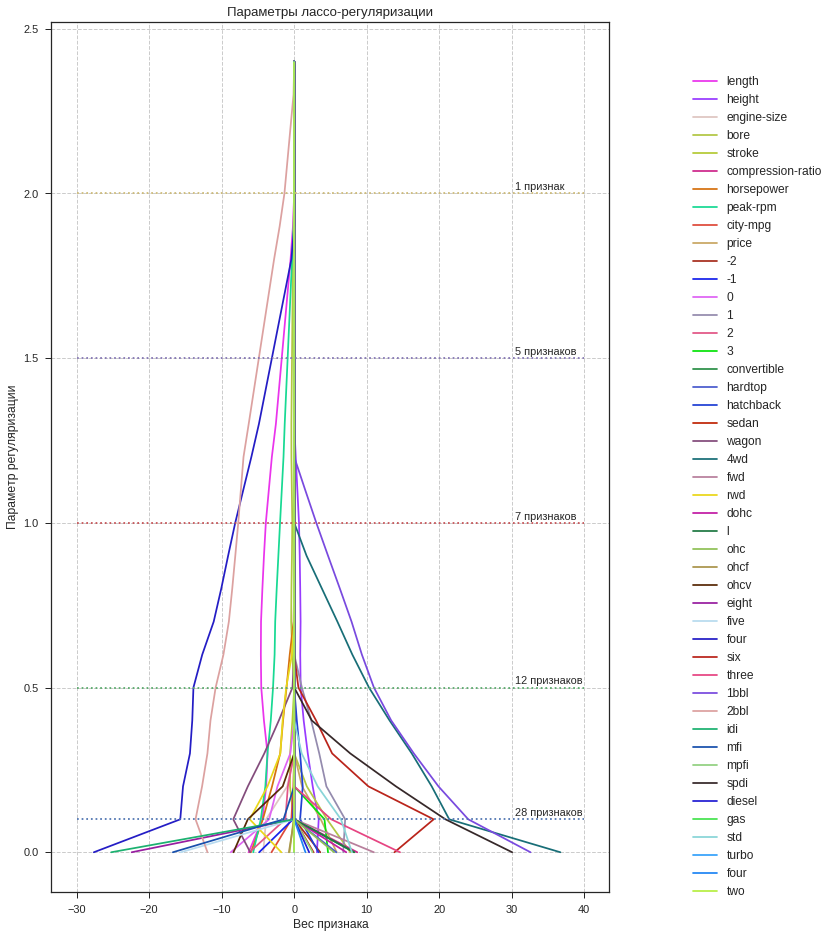

In [673]:
# Построим график, иллюстрирующий влияние параметра регуляризатора на значения коэффициентов модели

plt.figure(figsize=(10, 16))
for coef, feature in zip(coefs_lasso.T, df_full.columns):
    plt.plot(coef, alphas, label=feature, color=np.random.rand(3))
    
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95), fontsize = 12)
plt.grid(ls = 'dashed')
plt.plot([-30, 40], [0.10, 0.10], ls = 'dotted')
plt.text(30.5, 0.11, u'%s признаков' % non_zero_coefs[1], fontsize = 11)
plt.plot([-30, 40], [0.50, 0.50], ls = 'dotted')
plt.text(30.5, 0.51, u'%s признаков' % non_zero_coefs[5], fontsize = 11)
plt.plot([-30, 40], [1, 1], ls = 'dotted')
plt.text(30.5, 1.01, u'%s признаков' % non_zero_coefs[10], fontsize = 11)
plt.plot([-30, 40], [1.5, 1.5], ls = 'dotted')
plt.text(30.5, 1.51, u'%s признаков' % non_zero_coefs[15], fontsize = 11)
plt.plot([-30, 40], [2, 2], ls = 'dotted')
plt.text(30.5, 2.01, u'%s признак' % non_zero_coefs[20], fontsize = 11)
plt.ylabel(u"Параметр регуляризации")
plt.xlabel(u'Вес признака')
plt.title(u"Параметры лассо-регуляризации")
plt.show()

Видим, что большинство признаков "схлопывается" в ноль достаточно быстро с увеличением параметра регуляризации. Например, уже при коэффициенте штрафа 0.5 остается всего 12 ненулевых признаков из 46.

In [674]:
# Самые "влиятельные" признаки

regressor = linear_model.Lasso(alpha = 1.5, random_state = 2)
regressor.fit(df_full, target)

for cat, coef in zip(df_full.columns, regressor.coef_):
    if np.abs(coef) != 0:
        print (' '.join((str(cat), str(round(coef, 3)))))

length -1.719
bore -0.306
peak-rpm -0.906
four -3.08
2bbl -4.88


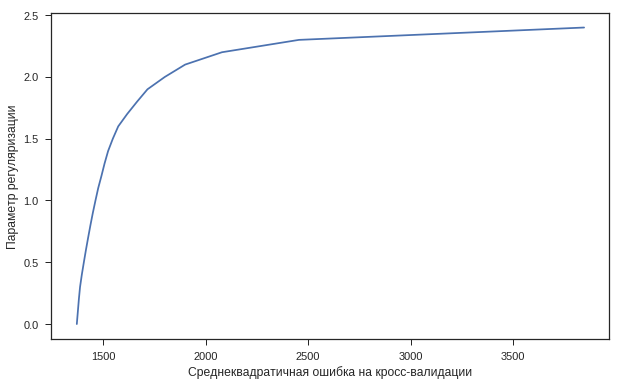

In [697]:
# Проведем подбор параметра регуляризации на кросс-валидации более формально

lasso_cv = linear_model.LassoCV(alphas = alphas, cv = 3)
lasso_cv.fit(df_full, target)

plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.mse_path_.mean(axis = 1), alphas)
plt.xlabel(u'Среднеквадратичная ошибка на кросс-валидации')
plt.ylabel(u'Параметр регуляризации')
plt.show()

array([ 1370.96504648,  1375.97621972,  1380.93816933,  1386.75017709,
        1395.41822252,  1405.29823304,  1415.49192061,  1426.26039154,
        1437.40858573,  1449.19191093,  1461.98785154,  1475.30459108,
        1491.31997893,  1506.45958598,  1523.58823343,  1546.68360667,
        1573.05440306,  1616.72227155,  1665.01712423,  1715.73327298,
        1800.35958312,  1899.49410232,  2079.27891223,  2454.68662375,
        3846.33565169])

In [1]:
lasso_p = linear_model.lasso_path(alphas = alphas, cv = 3)
lasso_p.fit(df_full, target)

NameError: name 'linear_model' is not defined

In [704]:
lasso_cv.coef_

array([-0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
       -0., -0.,  0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,
       -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0.,  0., -0.,  0.])

In [548]:
linereg.score(test_data, test_labels)

-2.2423764593453783

In [356]:
linereg.coef_

array([ -6.29193096,   3.13407812,  -4.27869231,   7.74095456,
        -0.64002755,   8.71464069,  -5.97247833,  -5.66019584,
        -3.1353807 ,   5.86417719,   4.39049838,  -4.04732171,
        -7.96162147,   7.55060098,  -5.38833486,   5.45617868,
         5.43236738,   3.01874329,   0.55849402,  -0.13343431,
        -8.87617039,  21.41220809,  -4.32019947, -17.09200862,
         4.81141353,   5.93851394,   3.1202844 ,  -3.11360727,
       -10.7566046 , -14.97172483,  -8.18773942, -20.19167512,
        21.29094727,  22.0601921 ,  27.20771294, -17.35996722,
        -9.54220643, -22.13704207,  -2.85010841,  24.68161119,
        -9.54220643,   9.54220643,   3.98205634,  -3.98205634,
         0.77440859,  -0.77440859])

In [361]:
knn = neighbors.KNeighborsRegressor()
knn.fit(df_full, target)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [364]:
knn.score(df_full, target)

0.18345037784662754

In [544]:
SGD = linear_model.SGDRegressor(n_iter=1000)
SGD.fit(df_full, target)
SGD.score(df_full, target)

0.15484822066386661

In [543]:
net = linear_model.ElasticNet()
net.fit(df_full, target)
net.score(df_full, target)

0.033251750722592566

In [542]:
bayes = linear_model.BayesianRidge()
bayes.fit(df_full, target)
bayes.score(df_full, target)

9.8151575881333386e-06

In [541]:
logreg = linear_model.LogisticRegression()
logreg.fit(train_data, train_labels)
logreg.score(test_data, test_labels)

0.041666666666666664

In [537]:
logistic = linear_model.LogisticRegressionCV(cv = 3, random_state = 6)
logistic.fit(train_data, train_labels)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=6,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [538]:
logistic.score(test_data, test_labels)

0.041666666666666664

In [533]:
svmreg = svm.SVR()
svmreg.fit(df_full, target)
svmreg.score(df_full, target)

-0.05240405440066831

In [532]:
kernel = kernel_ridge.KernelRidge()
kernel.fit(df_full, target)
kernel.score(df_full, target)

0.15079630398793142

In [535]:
forest = ensemble.RandomForestRegressor(n_estimators = 100, max_features = df_full.shape[1], random_state = 5)
forest.fit(train_data, train_labels)
forest.score(test_data, test_labels)

-0.28824524008508967

In [522]:
cross_validation.cross_val_score(forest, test_data, test_labels, scoring='r2', cv = 5).mean()

-0.053696320652723339

In [536]:
GBR = ensemble.GradientBoostingRegressor(n_estimators=1000).fit(train_data, train_labels)
cross_validation.cross_val_score(GBR, test_data, test_labels, scoring='neg_mean_absolute_error', cv = 3).mean()

-32.20809908876933

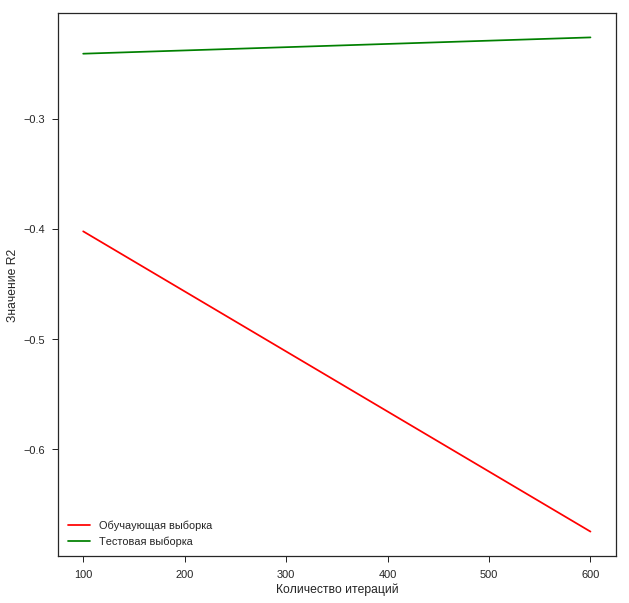

CPU times: user 1.46 s, sys: 328 ms, total: 1.78 s
Wall time: 1.41 s


In [531]:
%%time
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df_full, target, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 102)
ns = np.arange(100, 1100, 500)
score_train = []
score_test = []
for n in ns:
    GBR = ensemble.GradientBoostingRegressor(n_estimators = n).fit(df_full, target)
    score_train.append(cross_validation.cross_val_score(GBR, df_full, target, 
                                                        scoring = 'r2',cv = 3).mean())
    score_test.append(cross_validation.cross_val_score(GBR, test_data, test_labels, 
                                                       scoring = 'r2', cv = 3).mean())
    
plt.figure(figsize = (10, 10))

plt.plot(ns, score_train, color = 'red', label = u'Обучаующая выборка')
plt.plot(ns, score_test, color = 'green', label = u'Тестовая выборка')
plt.xlabel(u'Количество итераций')
plt.ylabel(u'Значение R2')
plt.legend()
plt.show()

In [528]:
score_train

[-0.39717443765922184,
 -0.51774277460354401,
 -0.60234217979250149,
 -0.62837235115530188,
 -0.67383980045235636,
 -0.60387099714088743,
 -0.63652609070720056,
 -0.64983822589323659,
 -0.59171647209991896,
 -0.62820660535751249]